In [1]:
%load_ext tensorboard
import tensorflow as tf
import sklearn as sk 
import matplotlib.pyplot as plt
import cv2 as cv 
import keras 
import os 
import pandas as pd
from PIL import Image
import itertools 
from sklearn.datasets import *
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model 
import random 
from keras.layers import *
import numpy as np
from datasets import Dataset
import datetime

In [2]:
tensor = {
    "train": ...,
    "test": ..., 
    "valid": ..., 
} 
path = {
    "train":".\\data\\imgs\\compress\\train",
    "test":".\\data\\imgs\\compress\\test", 
    "valid":".\\data\\imgs\\compress\\valid" 
} 
classes = []
 

In [3]:
image_height = 64
image_width = 64
batch_size = 32

In [4]:

def create_dataset(directory):
    return keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        color_mode='grayscale',
        label_mode='categorical' if directory != path["test"] else None,
        shuffle=True if directory == path["train"] else False,
        seed=42,
    )


In [5]:

# Create DataFrame for test images
test_filenames = os.listdir(path["test"])
test_df = pd.DataFrame({
    'filename': test_filenames
})



In [6]:

# Create datasets for train, valid, and test sets
train_dataset = create_dataset(path["train"])
valid_dataset = create_dataset(path["valid"])
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = Dataset.from_pandas(test_df)

Found 87000 files belonging to 29 classes.
Found 870 files belonging to 29 classes.


In [7]:
tensor["train"] = train_dataset
tensor["valid"] = valid_dataset
tensor["test"] = test_dataset

In [8]:
def _prefetch_to_tensor(dataset):
    dataset = dataset.take(1)
    np_arr = next(iter(dataset))
    t = tf.convert_to_tensor(np_arr)
    return t

In [9]:
train = list(tensor["train"])
valid = list(tensor["valid"])

In [10]:
def convert(data: list[tuple[tf.Tensor,tf.Tensor]]):
    nparr = []
    nplabel = []
    for i in data:
        for x in i[0]:
            nparr.append(tf.squeeze(x).numpy())
        for y in i[1]:
            nplabel.append(y.numpy())
    arr = np.array(nparr)
    labels = np.array(nplabel)
    return arr, labels

In [11]:
train_data,train_labels = convert(train)
valid_data,valid_labels = convert(valid)

In [12]:
train_data.shape,train_labels.shape, valid_data.shape,valid_labels.shape

((87000, 64, 64), (87000, 29), (870, 64, 64), (870, 29))

In [13]:
# Normalize
norm_train = train_data/255.0
norm_valid = valid_data/255.0
norm_train[:5],norm_valid[:5]

(array([[[0.10196079, 0.11372549, 0.10588235, ..., 0.12156863,
          0.1254902 , 0.12941177],
         [0.11372549, 0.3019608 , 0.32156864, ..., 0.2901961 ,
          0.5058824 , 0.54901963],
         [0.10980392, 0.20784314, 0.2       , ..., 0.5686275 ,
          0.5254902 , 0.5294118 ],
         ...,
         [0.14901961, 0.65882355, 0.6509804 , ..., 0.48235294,
          0.48235294, 0.49019608],
         [0.13725491, 0.6431373 , 0.6392157 , ..., 0.47058824,
          0.48235294, 0.4862745 ],
         [0.13333334, 0.64705884, 0.6392157 , ..., 0.45490196,
          0.4745098 , 0.48235294]],
 
        [[0.09803922, 0.10196079, 0.11764706, ..., 0.10196079,
          0.11764706, 0.12941177],
         [0.10980392, 0.3254902 , 0.3254902 , ..., 0.31764707,
          0.54901963, 0.5764706 ],
         [0.11372549, 0.21568628, 0.2       , ..., 0.5568628 ,
          0.5568628 , 0.54901963],
         ...,
         [0.14509805, 0.68235296, 0.6784314 , ..., 0.5058824 ,
          0.50980395, 0.

In [14]:
int_train_labels = np.argmax(train_labels,axis=1)
int_valid_labels = np.argmax(valid_labels,axis=1)
int_train_labels.shape,int_valid_labels.shape

((87000,), (870,))

In [15]:
def create_model():
    return keras.Sequential([
        Input(shape=(64, 64, 1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(29, activation='softmax')

    ])

In [16]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 22452), started 1 day, 18:37:23 ago. (Use '!kill 22452' to kill it.)

In [17]:
def train_model():
    model = create_model()
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    history = model.fit(norm_train,
                        int_train_labels,
                        validation_data=(
                            norm_valid,
                            int_valid_labels
                        ),
                        epochs=100,
                        callbacks=[tensorboard_callback])
    return history, model

In [18]:
history,_ = train_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,167,069 (8.27 MB)

 Trainable params: 2,167,069 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.0340 - loss: 4.4679 - val_accuracy: 0.0345 - val_loss: 3.3723
Epoch 2/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.0335 - loss: 3.3697 - val_accuracy: 0.0345 - val_loss: 3.3713
Epoch 3/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.0356 - loss: 3.3695 - val_accuracy: 0.0345 - val_loss: 3.3693
Epoch 4/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.0354 - loss: 3.3696 - val_accuracy: 0.0345 - val_loss: 3.3700
Epoch 5/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.0348 - loss: 3.3696 - val_accuracy: 0.0345 - val_loss: 3.3709
Epoch 6/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.0339 - loss: 3.3698 - val_accuracy: 0.0345 - val_loss: 3.3698
Epoch 7/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.0340 - loss: 3.3696 - val_accuracy: 0.0345 - val_loss: 3.3692
Epoch 8/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 

<Axes: >

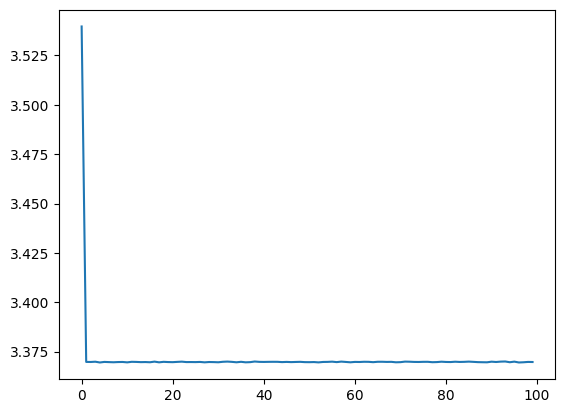

In [19]:
pd.DataFrame(history.history)["loss"].plot()


<Axes: >

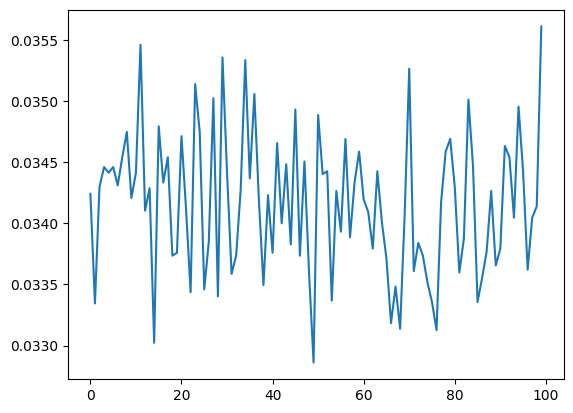

In [20]:
pd.DataFrame(history.history)["accuracy"].plot()


<Axes: >

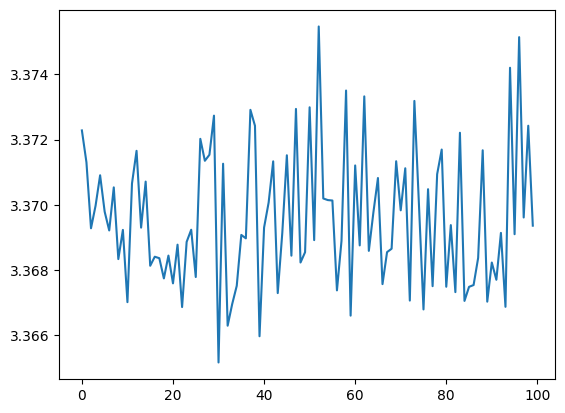

In [21]:
pd.DataFrame(history.history)["val_loss"].plot()


<Axes: >

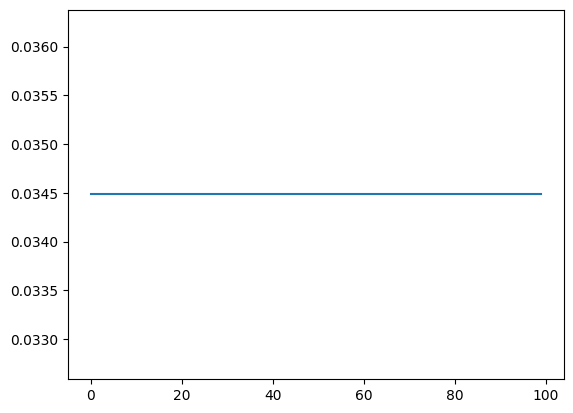

In [22]:
pd.DataFrame(history.history)["val_accuracy"].plot()

In [40]:
test_set = [tf.convert_to_tensor(plt.imread(os.path.join(path["test"],i))) for i in os.listdir(path["test"])]
test_set = tf.cast(test_set,dtype=tf.float32)/255.0
test_set[0].shape

TensorShape([64, 64])

In [46]:
pred = _.predict(test_set)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.03671188, 0.03384092, 0.03508193, 0.03343956, 0.03680263,
        0.03504646, 0.03156802, 0.03470829, 0.03428193, 0.03303111,
        0.03737196, 0.04041051, 0.03593826, 0.03338731, 0.03470882,
        0.0349375 , 0.0374829 , 0.03239075, 0.02931597, 0.03443338,
        0.03533169, 0.03185356, 0.03314517, 0.03491673, 0.03505328,
        0.0353334 , 0.03311892, 0.03218593, 0.03417118],
       [0.03671188, 0.03384092, 0.03508193, 0.03343956, 0.03680263,
        0.03504646, 0.03156802, 0.03470829, 0.03428193, 0.03303111,
        0.03737196, 0.04041051, 0.03593826, 0.03338731, 0.03470882,
        0.0349375 , 0.0374829 , 0.03239075, 0.02931597, 0.03443338,
        0.03533169, 0.03185356, 0.03314517, 0.03491673, 0.03505328,
        0.0353334 , 0.03311892, 0.03218593, 0.03417118],
       [0.03671188, 0.03384092, 0.03508193, 0.03343956, 0.03680263,
        0.03504646, 0.03156802, 0.03470829, 0.03428193, 0.03303111,
        0.03737196, 0.04041051, 0.03593826, 0.03338731, 0.03470882,
  